# CNN Johann Sebastian Bach

Bach is our first and best proposal to solve the Music classification problem using DNNs. This is the first of the two notebooks presented as solutions. We used the GTZAN dataset, which we found to be extremely limited without very specific preprocessing techniques that we will explain in the following chapters of these notebooks. Since this dataset was very limited, we decided to take out only 5 files from  each genre and used the other 950 files as training and validation in the DNN. This means the validation leaks into the training, we are aware of this, we made tests avoiding this but data became too limited and the DNN hardly made any progress. This is where those other 50 files come into play, Those are the real "test" and as we will thanks to the structure the DNN generalizes with almost no fault and classifies those files that it has never seen with no problem.

## Dependencies

Nothing out of the ordinary, librosa is the main library to preprocess .wav files and get vectors that we can process.

In [1]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

#KERAS
from keras.callbacks import EarlyStopping
from keras.layers import LSTM
from keras.layers import recurrent, Conv1D, MaxPooling1D
from keras.layers.core import Dense, Flatten, Dropout
from keras.models import Sequential
from keras.preprocessing import sequence
from keras.utils import to_categorical
from tensorflow import keras

#PLOTTING
import matplotlib.pyplot as plt

#DATA
from sklearn.model_selection import train_test_split
import os
import librosa
import numpy as np

min = 660000

Instructions for updating:
non-resource variables are not supported in the long term


# Preprocessing

The first step is to access the .wav files. Each file is in a folder with the label of the genre so we will have to iterate through these folders, we will use 'os' for this and to check if it is a directory since we only want to move into the folders and into any other to or file.

## Wave to vector

We used librosa’s load module to get the data with a sample rate of 22050.

## Formatting the data

As it is to be expected not all the files gave vectors of the same size, we made a preliminary analysis of this and concluded to cut them short at 660000 numbers since this would mean we normalize the data shape and lose barely any information from the music. Once the data has been reduced to the same size, it is time to start making splits. 

First, each .wav will be split into 100 segments making each segment around 0.3 seconds long and then reshaping into a 2 dimensional array of shape (60,100). This rises up some questions, "is it possible to detect the genre of a song from only 0.3 seconds?" Yes, it is not easy but with the right amount of data dropout and the correct data format it's possible.

## Classes

We decided to use One Hot Encoding as the data format for our classes. These arrays are made at the same time the data is being formatted. since the data is in order we just have to change the index we put as 1 every X examples.


In [2]:
def load_audio(filename, sample_rate=22050, dtype=np.float32) -> np.ndarray:
    
    dtype = np.dtype(dtype)
    wave, sr = librosa.load(filename, sr=sample_rate, mono=True, dtype=dtype)
    return wave, sr


def gather_data(path):

    music = []
    for dir0 in os.listdir(path):
        
        full_path=os.path.join(path, dir0) 
        
        if os.path.isdir(full_path):
            print(dir0)
            
            for file in os.listdir(full_path):
                
                music_path=os.path.join(full_path, file)
                y, _ = load_audio(music_path) 
                music.append(y)
            
    return np.array(music)  

#a = gather_data("./genres")

def gather_data_test(path):

    music = []
        
    for file in os.listdir(path):
            
        music_path=os.path.join(path, file)
        y, _ = load_audio(music_path) 
        music.append(y)
            
    return np.array(music)  


def format_data_test(data):
    splitedData = []
    classes = []
    n = 0
    
    mod = []
    for i in data:
        i = i[:660000]
        a = np.split(i,100)
        for j in a:
            mod.append(j)
    mod = np.array(mod)
    for i in range(mod.shape[0]):
        ohe = np.zeros(10)
        if i % 500 == 0 and i != 0:
            n +=1
        wav = mod[i]
        wavList = np.split(wav, 60)
        splitedData.append(wavList)
        ohe[n] = 1
        classes.append(ohe)
    return np.array(splitedData), np.array(classes)    

def format_data(data):
    splitedData = []
    classes = []
    n = 0
    
    mod = []
    for i in data:
        i = i[:660000]
        a = np.split(i,100)
        for j in a:
            mod.append(j)
    mod = np.array(mod)
    for i in range(mod.shape[0]):
        ohe = np.zeros(10)
        if i % 9500 == 0 and i != 0:
            n +=1
        wav = mod[i]
        wavList = np.split(wav, 60)
        splitedData.append(wavList)
        ohe[n] = 1
        classes.append(ohe)
    return np.array(splitedData), np.array(classes)


def get_batch(data,classes, batch_size = 100):
   indices = np.random.permutation(data.shape[0])[0:batch_size]
   return data[indices] , classes[indices]

## Readying the data

Once again we decided to use the train_test_split for convenience. The validation portion has to be small in order to feed enough information to the Bach to learn segments of 0.3s.

In [3]:
data = gather_data("./genres")
X, Y = format_data(data)
train_data, valid_data, train_target, valid_target = train_test_split(X,Y, test_size= 0.1, random_state=31 )
print(X.shape, Y.shape)
X[:10]

blues
classical
country
disco
hiphop
jazz
metal
pop
reggae
rock
(95000, 60, 110) (95000, 10)


array([[[ 7.32421875e-03,  1.66015625e-02,  7.62939453e-03, ...,
         -2.27661133e-02, -1.89514160e-02, -3.24707031e-02],
        [-3.46679688e-02, -2.36816406e-02, -2.19116211e-02, ...,
          5.82885742e-03,  3.35693359e-03,  5.00488281e-03],
        [ 3.50952148e-03, -8.33129883e-03, -1.71508789e-02, ...,
          1.18103027e-02,  1.58386230e-02,  2.59704590e-02],
        ...,
        [ 9.51843262e-02,  6.59484863e-02,  6.16149902e-02, ...,
          2.74658203e-03,  2.67333984e-02,  7.17468262e-02],
        [ 1.24664307e-01,  1.49383545e-01,  1.32202148e-01, ...,
          2.00775146e-01,  1.72851562e-01,  1.27136230e-01],
        [ 1.08795166e-01,  1.08337402e-01,  1.17187500e-01, ...,
          5.88989258e-03,  7.33337402e-02,  9.62219238e-02]],

       [[ 7.98034668e-02,  4.38232422e-02,  3.05175781e-03, ...,
          6.19812012e-02,  1.01715088e-01,  1.69555664e-01],
        [ 2.39379883e-01,  2.84301758e-01,  3.11676025e-01, ...,
         -2.36083984e-01, -2.38555908e

# Johann Sebastian Bach

## Neurons
We named this CNN after Bach in honor to the great compositor. First, let's talk about the neurons, too many and the data will be too sparse, too few and it will overwhelm. This shape allows for an entry almost the shape of the amount of columns on the input with an expansion in the middle and back down again before the flatting to a dense layer of size 10. This structure proved to work faster and to learn more details. We used Con1v because our data has two dimensions since it is merely a split array.

## Activation

It comes as no surprise to see ReLU as the activation  function int the Con1v, it did indeed prove to be the best one. However in the dense layer softmax is the best option since it will assign a probability to each class.

## Dropout

Dropout is key, without it, the model learns the training set in less than a 100 epochs since it is very small, leaving the validation set at a mere 30% accuracy. Implementing dropout at each layer with a little emphasis for the last one proved to be the best way of having the validation data and the training data progress at the same rate.

## Pooling

Pooling can be used but it will only give slightly worse results and costs more time, although we did save a model trained with pooling, it presented no advantage over the model without it.




In [4]:
Johann_Sebastian_Bach = Sequential()

Johann_Sebastian_Bach.add(Conv1D(100, 5, activation = 'relu', input_shape = X.shape[1:] ))
#Johann_Sebastian_Bach.add(MaxPooling1D( pool_size= 2))
Johann_Sebastian_Bach.add(Dropout(0.2))

Johann_Sebastian_Bach.add(Conv1D(300,3, activation = 'relu' ))
#Johann_Sebastian_Bach.add(MaxPooling1D( pool_size= 2))
Johann_Sebastian_Bach.add(Dropout(0.2))

Johann_Sebastian_Bach.add(Conv1D(180,2, activation = 'relu' ))
#Johann_Sebastian_Bach.add(MaxPooling1D( pool_size= 2))
Johann_Sebastian_Bach.add(Dropout(0.2))

Johann_Sebastian_Bach.add(Flatten())
Johann_Sebastian_Bach.add(Dropout(0.3))

Johann_Sebastian_Bach.add(Dense(10, activation='softmax'))
opt = keras.optimizers.Adam(learning_rate=0.0001)
Johann_Sebastian_Bach.compile(loss="categorical_crossentropy", optimizer=opt, metrics=['categorical_crossentropy','accuracy'])

In [5]:
Johann_Sebastian_Bach.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 56, 100)           55100     
_________________________________________________________________
dropout (Dropout)            (None, 56, 100)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 54, 300)           90300     
_________________________________________________________________
dropout_1 (Dropout)          (None, 54, 300)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 53, 180)           108180    
_________________________________________________________________
dropout_2 (Dropout)          (None, 53, 180)           0         
_________________________________________________________________
flatten (Flatten)            (None, 9540)              0

# Training

This cell can be used to train the model 100 epochs are enough to get decent accuracy but to get to the point of our model 600 epochs are necessary. Please note this took several hours so train at your own risk. A strong GPU is suggested.


In [ ]:
history = Johann_Sebastian_Bach.fit(train_data, train_target, batch_size= 200, epochs= 96, validation_data=(valid_data,valid_target))

Johann_Sebastian_Bach.save("Bach_new.h5")

# Losses

We used the categorical crossentropy loss function for obvious reasons and as can be seen below at around 100 epochs the loss starts plateauing but if you let it run for another 400 epochs you approach the 0.2 mark ever so slowly.

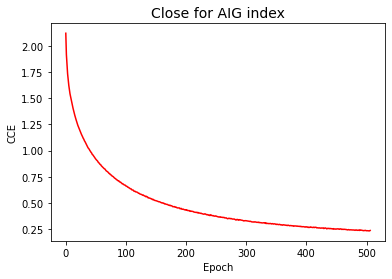

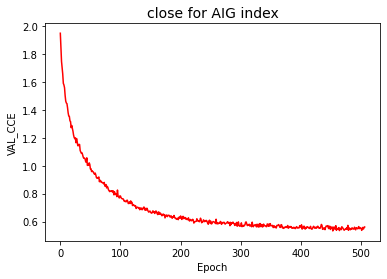

In [7]:
plt.title("CCE through the epochs", fontsize=14)
plt.plot(history.history["categorical_crossentropy"],'r-')
plt.xlabel("Epoch")
plt.ylabel("CCE")
plt.show()

plt.title("Validation CCE through the epochs", fontsize=14)
plt.plot(history.history["val_categorical_crossentropy"],'r-')
plt.xlabel("Epoch")
plt.ylabel("VAL_CCE")
plt.show()

# Testing

This is where those previously mentioned 50 files come into play. The validation part was used to let Bach get as much info to learn the patterns in 0.3s of information. This means that validation data can not really be trusted and this is why we are going to use these files. Since these files have never been imputed to Johan we will see how accurate the CNN really is.


In [6]:
test = gather_data_test("./test")
test_data, test_target = format_data_test(test)

print(test_data.shape, test_target.shape)

(5000, 60, 110) (5000, 10)


# Final results

Below are the results of the three subsets we got and as can be seen we get a very good generalization from this approach we can classify an 0.3 second segment with 82% accuracy. But this is not the end of it. Let's go back to the beginning. Our wav files have a length of 30 second which means we can extract 100 0.3s segments. Now let's input all these segments into Bach. Let's do a small statistical analysis of the chances of getting the wrong answer. Let's assume every class has the same chance of being selected between the ones that are wrong. Meaning every wrong class hacs 0.18/9 chance of being predicted individually. The least amount of times a class needs to me predicted to have a majority is 11 since there are 10 classes meaning the highest chance of getting the wrong classification on a 30s audio is => (0.18/9)^11 = 2.048e-19. Obviously these are incredible results and the best part is we can get ~1 accuracy while avoiding overfitting thanks to predicting segment by segment. Obviously these only happen if each genre was learnt exactly the same as the other and the song didn't vary that much. In practice we will see some songs are harder than others to predict because of their unique flavours.


In [7]:
Johann_Sebastian_Bach = keras.models.load_model("Bach_no_pooling_out_files.h5")

Johann_Sebastian_Bach_train_error = Johann_Sebastian_Bach.evaluate(train_data, train_target, batch_size=200)
Johann_Sebastian_Bach_valid_error = Johann_Sebastian_Bach.evaluate(valid_data, valid_target, batch_size=200)
Johann_Sebastian_Bach_test_error = Johann_Sebastian_Bach.evaluate(test_data, test_target, batch_size=200)

print("The training error for Bach is:",Johann_Sebastian_Bach_train_error)
print("The training valid for Bach is:",Johann_Sebastian_Bach_valid_error )
print("The training test for Bach is:",Johann_Sebastian_Bach_test_error)



Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
The training error for Bach is: [0.12842287097932303, 0.96502924]
The training valid for Bach is: [0.13360253933228944, 0.96378946]
The training test for Bach is: [1.2944281984120607, 0.8258]


## Example

Below we leave an example on how to predict a particular song and as a demonstration of how that accuracy is achieved without overfitting.

In [14]:
one_song = test_data[:100,:,:] #blues song
print(one_song.shape)
res = Johann_Sebastian_Bach.predict(one_song)
cont = np.zeros((10))
for i in range(res.shape[0]):
    idx = np.where(res[i] == res[i].max())
    cont[idx] += 1
print(cont)

(100, 60, 110)
[94.  0.  3.  0.  0.  2.  0.  0.  0.  1.]


## Detailed confusion Matrix
We can obtain a detailed confusion matrix of how were classified each segment of each song in the following way:

In [40]:
contL =cont = np.zeros((50,10))
idx = 0
i = 0

while i < test_data.shape[0]:
    #print(i)
    song = test_data[i:(i+100),:,:]
    res = Johann_Sebastian_Bach.predict(song)
    for j in range(res.shape[0]):
        max_idx = np.where(res[j] == res[j].max())
        #print(max_idx[0][0])
        contL[idx][max_idx] += 1
    i += 100
    idx += 1
print(contL)

[[ 94.   0.   3.   0.   0.   2.   0.   0.   0.   1.]
 [100.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [100.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [ 79.   0.   7.   3.   4.   0.   7.   0.   0.   0.]
 [ 39.   1.  34.   5.   2.   5.   2.   1.   6.   5.]
 [  0. 100.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0. 100.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.  96.   0.   0.   0.   0.   0.   0.   4.   0.]
 [  0.  96.   0.   0.   0.   4.   0.   0.   0.   0.]
 [  0. 100.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.  99.   0.   0.   1.   0.   0.   0.   0.]
 [  0.   0.  98.   2.   0.   0.   0.   0.   0.   0.]
 [  0.   0.  98.   0.   0.   0.   0.   0.   0.   2.]
 [  0.   0.  81.   6.   0.   0.   0.   0.   0.  13.]
 [ 10.   1.  68.   0.   1.   0.  17.   0.   0.   3.]
 [  0.   0.   2.  92.   1.   0.   0.   1.   0.   4.]
 [  0.   0.   1.  96.   0.   0.   1.   0.   0.   2.]
 [  0.   0.   1.  90.   0.   0.   0.   9.   0.   0.]
 [  0.   0.   0.   4.  71.   0.  16.   8.   1.

# Accuracy

First we will get the index for the class out of every song. Since the song goes from 100 in 100 we can access the first array every hundred and get the class there. After that we just compare for each one if the position with the most prediction is the same that the one we got from the target. The results are obviously better than the ones we get from a single segment of 0.3s but obviously not as good as predicted. This becomes obvious if you look at the one we got wrong. Not all genres were learnt as good presumably because some may be more similar between themselves in certain songs.


In [62]:
acc = 0
#print(test_target[1])
new_test = np.zeros((50))
j = 0
idx = 0
while j < test_target.shape[0]:
    corr_idx = np.where(test_target[j] == test_target[j].max())
    new_test[idx] = corr_idx[0][0]
    j+= 100
    idx += 1
print(new_test.shape)

wrong = []

for i in range(contL.shape[0]):
    max_idx = np.where(contL[i] == contL[i].max())
    if max_idx[0][0] == new_test[i]:
        acc += 1
    else:
        wrong.append(i)
print(acc/contL.shape[0])
print("this are the one we got wrong", wrong)



[0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 2. 2. 2. 2. 2. 3. 3. 3. 3. 3. 4. 4. 4. 4.
 4. 5. 5. 5. 5. 5. 6. 6. 6. 6. 6. 7. 7. 7. 7. 7. 8. 8. 8. 8. 8. 9. 9. 9.
 9. 9.]
0.9
this are the one we got wrong [18, 19, 28, 39, 44]
